In [144]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import csv
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from collections import Counter 
import string
from nltk.tokenize import word_tokenize
from langdetect import detect
nltk.download("vader_lexicon")
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy import stats
import statsmodels.api
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/merlekuehlenborg/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [145]:
#Loading the dataset
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)

df_trustpilot = pd.read_csv('data/data_trustpilot_first.csv', engine='python')

#Displaying basic information
print(df_trustpilot.columns)
print(df_trustpilot.info())
display(df_trustpilot.head())


Index(['username', 'number_reviews', 'location', 'rating', 'text',
       'date_of_experience', 'date_posted', 'verification', 'subject',
       'answer', 'company'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78404 entries, 0 to 78403
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   username            78401 non-null  object
 1   number_reviews      78404 non-null  int64 
 2   location            78404 non-null  object
 3   rating              78404 non-null  int64 
 4   text                78404 non-null  object
 5   date_of_experience  78404 non-null  object
 6   date_posted         78404 non-null  object
 7   verification        78404 non-null  object
 8   subject             78404 non-null  object
 9   answer              78404 non-null  object
 10  company             78404 non-null  object
dtypes: int64(2), object(9)
memory usage: 6.6+ MB
None


,username,number_reviews,location,rating,text,date_of_experience,date_posted,verification,subject,answer,company
0,Rob Crane,2,CA,5,The company rep I worked with made my transact...,2024-06-15,2024-10-23 04:17:44,Redirected,The company rep I worked with made my…,0,Flashbay
1,Pat Anderson,1,US,5,I highly recommend using Flashbay. Immediately...,2024-10-16,2024-10-16 19:34:05,Verified,I highly recommend using Flashbay,0,Flashbay
2,Margarita Orlova,1,CZ,5,I had the pleasure of working with Shelby Gibs...,2024-10-10,2024-10-17 10:27:44,Verified,Great customer service,0,Flashbay
3,Paola Rivas,1,US,5,I had a fantastic experience with Brian Truong...,2024-10-21,2024-10-21 22:38:50,Verified,Outstanding Support and Attentive Service,0,Flashbay
4,Fiona Mckelvey Keenan,3,CA,5,My number-one go-to for computer accessories. ...,2024-07-11,2024-10-23 04:09:05,Not Verified,My number-one go-to for computer…,0,Flashbay


In [146]:
#Remove non-EN content

stop_words = set(stopwords.words('english'))

# Function to check if text is English
def is_english(text):
   try:
       if isinstance(text, str) and text.strip():
           return detect(text) == 'en'
       return False
   except:
       return False

# Remove non-English content from both text and subject columns
df_trustpilot['text_is_english'] = df_trustpilot['text'].apply(is_english)
df_trustpilot['subject_is_english'] = df_trustpilot['subject'].apply(is_english)

# Keep only rows where both text and subject are in English
df_trustpilot = df_trustpilot[df_trustpilot['text_is_english'] & df_trustpilot['subject_is_english']]
print("Number of rows after removing non-English content:", len(df_trustpilot))
df_trustpilot = df_trustpilot.drop(['text_is_english', 'subject_is_english'], axis=1)


Number of rows after removing non-English content: 64414


STAGE 1 - CREATING NEW COLUMNS

In [147]:
#convert date_posted and date_of_experience to datetime
df_trustpilot['date_posted'] = pd.to_datetime(df_trustpilot['date_posted'])
df_trustpilot['date_of_experience'] = pd.to_datetime(df_trustpilot['date_of_experience'])

#Create local_hour and local_date_posted
#Fixing the date_posted column
#The date_posted is from the CET timezone, however, there are countries in the list that are in a different timezone.
#That way, if someone posts at 9 pm in New York City, it appears as 3 am CET, potentially skewing the data.
#We need to fix this column so that date_posted represents the original date and time posted, from the view of the user writing the review.
#Maps the timezone difference from the view of the CET timezone

timezone_offsets = {
    # Western Europe (CET/CEST)
    'DE': 0, 'FR': 0, 'IT': 0, 'ES': 0, 'NL': 0, 'BE': 0, 'AT': 0, 'CH': 0, 'SE': 0,
    'DK': 0, 'NO': 0, 'PL': 0, 'CZ': 0, 'PT': 0, 'HU': 0, 'SK': 0, 'SI': 0, 'LU': 0,
    'MT': 0, 'HR': 0, 'BA': 0, 'AL': 0, 'ME': 0, 'RS': 0, 'MK': 0, 'AD': 0, 'LI': 0,
    # Eastern Europe
    'FI': 1, 'EE': 1, 'LV': 1, 'LT': 1, 'UA': 1, 'RO': 1, 'BG': 1, 'GR': 1, 'BY': 1,
    'MD': 1, 'TR': 1, 'CY': 1,
    # UK and related territories
    'GB': -1, 'IE': -1, 'IM': -1, 'JE': -1, 'GG': -1, 'GI': -1,
    # Russia and Central Asia
    'RU': 3, 'KZ': 4, 'UZ': 5, 'KG': 5,
    # North America and Greenland
    'US': -7, 'CA': -7, 'MX': -7, 'PR': -6, 'VI': -6, 'GU': 10, 'GL': -3,  
    # Central America and Caribbean
    'GT': -8, 'HN': -8, 'SV': -8, 'NI': -8, 'CR': -8, 'PA': -7,
    'BS': -7, 'CU': -7, 'JM': -7, 'DO': -6, 'BB': -6, 'TT': -6,
    'KN': -6, 'AG': -6, 'VC': -6, 'AI': -6, 'BM': -6, 'KY': -6,
    'TC': -6, 'AW': -6, 'CW': -6, 'BQ': -6, 'SX': -6, 'GP': -6,
    # South America
    'BR': -5, 'AR': -5, 'CL': -6, 'CO': -7, 'VE': -6, 'PE': -7,
    'EC': -7, 'BO': -6, 'PY': -6, 'UY': -5,
    # East Asia
    'CN': 7, 'JP': 8, 'KR': 8, 'TW': 7, 'MN': 7, 'HK': 7, 'MO': 7,
    # Southeast Asia
    'SG': 7, 'MY': 7, 'ID': 7, 'TH': 7, 'VN': 7, 'PH': 7,
    'MM': 6.5, 'KH': 7, 'BN': 7,
    # South Asia
    'IN': 4.5, 'PK': 4, 'BD': 5, 'NP': 4.75, 'LK': 4.5, 'MV': 4,
    # Central Asia and Middle East
    'AE': 3, 'SA': 2, 'IL': 2, 'IR': 2.5, 'IQ': 2, 'OM': 3,
    'KW': 2, 'QA': 2, 'BH': 2, 'JO': 2, 'LB': 2, 'AF': 3.5,
    'AM': 3, 'AZ': 3, 'GE': 3,
    # Oceania
    'AU': 9, 'NZ': 11, 'FJ': 11, 'PF': 10, 'MP': 9,
    # Africa
    'ZA': 1, 'EG': 1, 'MA': 0, 'DZ': 0, 'TN': 0, 'LY': 1,
    'NG': 0, 'GH': 0, 'KE': 2, 'UG': 2, 'RW': 1, 'CD': 1,
    'GA': 0, 'CM': 0, 'ZW': 1, 'CI': 0, 'SS': 2,  
    'RE': 3,  
    # European Islands and Territories
    'IS': -1, 'FO': -1, 'AX': 1,
    # Disputed or Special Territories
    'XK': 0}

#Checking whether there are countries missing in our dictionary that are present in our df
countries_in_df = df_trustpilot['location'].unique()
countries_in_mapping = set(timezone_offsets.keys())
missing_countries = set(countries_in_df) - countries_in_mapping
if len(missing_countries) > 0:
    print("Countries in dataset but not in timezone mapping:")
    print(missing_countries)
    print(f"Total missing countries: {len(missing_countries)}")
else:
    print("All countries in the dataset are covered in our timezone mapping!")

#Creating new columns local_hour and local_date_posted
def adjust_to_local_time(df_trustpilot):
    df_trustpilot['local_hour'] = None
    df_trustpilot['local_date_posted'] = None
    for country_code, offset in timezone_offsets.items():
        mask = df_trustpilot['location'] == country_code
        if offset != 0:  
            local_datetime = pd.to_datetime(df_trustpilot.loc[mask, 'date_posted']) + pd.Timedelta(hours=offset)
            df_trustpilot.loc[mask, 'local_date_posted'] = local_datetime.dt.date
            df_trustpilot.loc[mask, 'local_hour'] = local_datetime.dt.hour
    
    # Processing CET countries (offset = 0)
    cet_mask = df_trustpilot['location'].isin([k for k, v in timezone_offsets.items() if v == 0])
    cet_datetime = pd.to_datetime(df_trustpilot.loc[cet_mask, 'date_posted'])
    df_trustpilot.loc[cet_mask, 'local_date_posted'] = cet_datetime.dt.date
    df_trustpilot.loc[cet_mask, 'local_hour'] = cet_datetime.dt.hour
    
    # Evaluation steps
    def evaluate_timezone_adjustment():
        null_local_hour = df_trustpilot['local_hour'].isnull().sum()
        null_local_date = df_trustpilot['local_date_posted'].isnull().sum()
        invalid_hours = df_trustpilot[~df_trustpilot['local_hour'].between(0, 23)].shape[0]
        date_changes = (df_trustpilot['local_date_posted'] != 
                       pd.to_datetime(df_trustpilot['date_posted']).dt.date).sum()
        print("Evaluation Results:")
        print(f"Missing local hours: {null_local_hour}")
        print(f"Missing local dates: {null_local_date}")
        print(f"Invalid hours (not 0-23): {invalid_hours}")
        print(f"Number of date changes due to timezone adjustment: {date_changes}")
        if date_changes > 0:
            print("Sample of records where date changed:")
            date_change_mask = (df_trustpilot['local_date_posted'] != 
                              pd.to_datetime(df_trustpilot['date_posted']).dt.date)
            sample_changes = df_trustpilot[date_change_mask].sample(min(5, date_changes))
            print(sample_changes[['location', 'date_posted', 'local_date_posted', 'local_hour']].to_string())
    evaluate_timezone_adjustment()

    return df_trustpilot

# Applying the function and overwriting the existing dataframe
df_trustpilot = adjust_to_local_time(df_trustpilot)

df_trustpilot['local_hour'] = df_trustpilot['local_hour'].astype('int')
df_trustpilot['local_date_posted'] = pd.to_datetime(df_trustpilot['local_date_posted'])



All countries in the dataset are covered in our timezone mapping!
Evaluation Results:
Missing local hours: 0
Missing local dates: 0
Invalid hours (not 0-23): 0
Number of date changes due to timezone adjustment: 8230
Sample of records where date changed:
      location         date_posted local_date_posted local_hour
7530        US 2017-05-25 01:32:19        2017-05-24         18
26591       US 2021-03-29 04:16:59        2021-03-28         21
32857       US 2019-04-29 02:05:04        2019-04-28         19
14416       US 2014-09-25 00:10:44        2014-09-24         17
12550       US 2015-08-05 03:15:03        2015-08-04         20


In [148]:
#Creating days_between_experience_and_post
df_trustpilot['days_between_experience_and_post'] = (df_trustpilot['local_date_posted'] - df_trustpilot['date_of_experience']).dt.days

# Creating day_of_week_posted by extracting day of week (Monday=0, Sunday=6)
df_trustpilot['day_of_week_posted'] = df_trustpilot['local_date_posted'].dt.dayofweek

In [149]:
#Creating columns time_of_day, day_type and month_name

def create_time_features(df):
    def categorize_hour(hour):
        if 5 < hour <= 8:
            return 'Morning'
        elif 9 <= hour <= 17:
            return 'Business Hours'
        elif 18 <= hour <= 22:
            return 'Evening'
        else:
            return 'Night'
    def categorize_day(day):
        if day in [0, 1, 2, 3, 4]:  
            return 'Business Day'
        else:
            return 'Weekend'
    df['time_of_day'] = df['local_hour'].apply(categorize_hour)
    df['day_type'] = df['day_of_week_posted'].apply(categorize_day)
    df['month_name'] = df['local_date_posted'].dt.strftime('%B')
    return df

df_trustpilot = create_time_features(df_trustpilot)

#Printing distributions of new columns
print("Text columns distributions:")
text_columns = ['time_of_day', 'day_type', 'month_name']
for col in text_columns:
    print(f"{col} value counts:")
    print(df_trustpilot[col].value_counts())
print("Numeric columns statistics:")
print("Checking for null values in new columns:")
all_new_columns = text_columns 
print(df_trustpilot[all_new_columns].isnull().sum())

Text columns distributions:
time_of_day value counts:
time_of_day
Business Hours    37267
Morning           12469
Evening           10926
Night              3752
Name: count, dtype: int64
day_type value counts:
day_type
Business Day    52545
Weekend         11869
Name: count, dtype: int64
month_name value counts:
month_name
December     8968
April        6891
May          6672
March        6621
January      6316
February     6210
June         4674
August       3876
July         3869
October      3803
September    3271
November     3243
Name: count, dtype: int64
Numeric columns statistics:
Checking for null values in new columns:
time_of_day    0
day_type       0
month_name     0
dtype: int64


In [150]:
print(df_trustpilot.columns)
display(df_trustpilot.head())

Index(['username', 'number_reviews', 'location', 'rating', 'text',
       'date_of_experience', 'date_posted', 'verification', 'subject',
       'answer', 'company', 'local_hour', 'local_date_posted',
       'days_between_experience_and_post', 'day_of_week_posted', 'time_of_day',
       'day_type', 'month_name'],
      dtype='object')


,username,number_reviews,location,rating,text,date_of_experience,date_posted,verification,subject,answer,company,local_hour,local_date_posted,days_between_experience_and_post,day_of_week_posted,time_of_day,day_type,month_name
0,Rob Crane,2,CA,5,The company rep I worked with made my transact...,2024-06-15,2024-10-23 04:17:44,Redirected,The company rep I worked with made my…,0,Flashbay,21,2024-10-22,129,1,Evening,Business Day,October
1,Pat Anderson,1,US,5,I highly recommend using Flashbay. Immediately...,2024-10-16,2024-10-16 19:34:05,Verified,I highly recommend using Flashbay,0,Flashbay,12,2024-10-16,0,2,Business Hours,Business Day,October
2,Margarita Orlova,1,CZ,5,I had the pleasure of working with Shelby Gibs...,2024-10-10,2024-10-17 10:27:44,Verified,Great customer service,0,Flashbay,10,2024-10-17,7,3,Business Hours,Business Day,October
3,Paola Rivas,1,US,5,I had a fantastic experience with Brian Truong...,2024-10-21,2024-10-21 22:38:50,Verified,Outstanding Support and Attentive Service,0,Flashbay,15,2024-10-21,0,0,Business Hours,Business Day,October
4,Fiona Mckelvey Keenan,3,CA,5,My number-one go-to for computer accessories. ...,2024-07-11,2024-10-23 04:09:05,Not Verified,My number-one go-to for computer…,0,Flashbay,21,2024-10-22,103,1,Evening,Business Day,October


In [151]:
# Binary encoding for answer presence
# 0 = no answer provided
# 1 = answer provided 

df_trustpilot['answered_encoded'] = np.where(df_trustpilot['answer'] == '0', 0, 1).astype('int')

display(df_trustpilot.head())


,username,number_reviews,location,rating,text,date_of_experience,date_posted,verification,subject,answer,company,local_hour,local_date_posted,days_between_experience_and_post,day_of_week_posted,time_of_day,day_type,month_name,answered_encoded
0,Rob Crane,2,CA,5,The company rep I worked with made my transact...,2024-06-15,2024-10-23 04:17:44,Redirected,The company rep I worked with made my…,0,Flashbay,21,2024-10-22,129,1,Evening,Business Day,October,0
1,Pat Anderson,1,US,5,I highly recommend using Flashbay. Immediately...,2024-10-16,2024-10-16 19:34:05,Verified,I highly recommend using Flashbay,0,Flashbay,12,2024-10-16,0,2,Business Hours,Business Day,October,0
2,Margarita Orlova,1,CZ,5,I had the pleasure of working with Shelby Gibs...,2024-10-10,2024-10-17 10:27:44,Verified,Great customer service,0,Flashbay,10,2024-10-17,7,3,Business Hours,Business Day,October,0
3,Paola Rivas,1,US,5,I had a fantastic experience with Brian Truong...,2024-10-21,2024-10-21 22:38:50,Verified,Outstanding Support and Attentive Service,0,Flashbay,15,2024-10-21,0,0,Business Hours,Business Day,October,0
4,Fiona Mckelvey Keenan,3,CA,5,My number-one go-to for computer accessories. ...,2024-07-11,2024-10-23 04:09:05,Not Verified,My number-one go-to for computer…,0,Flashbay,21,2024-10-22,103,1,Evening,Business Day,October,0


In [152]:
# Calculate and display distribution statistics
total_users = len(df_trustpilot)
repeat = (df_trustpilot['number_reviews'] >= 2).sum()
pct_repeat = (repeat / total_users) * 100
onetime = (df_trustpilot['number_reviews'] < 2).sum()
pct_onetime = (onetime / total_users) * 100
print("Percentage of users with >= 2 reviews: ", pct_repeat)
print("Percentage of users with < 2 reviews: ", pct_onetime)

# Create categorical column for visualization/EDA
df_trustpilot['repeat_reviewer'] = np.where(df_trustpilot['number_reviews'] >= 2, 'repeat', 'one-time')

# Binary encode for modeling (0 = one-time, 1 = repeat)
df_trustpilot['repeat_reviewer_encoded'] = (df_trustpilot['number_reviews'] >= 2).astype('int')

display(df_trustpilot.head())

Percentage of users with >= 2 reviews:  43.78706492377433
Percentage of users with < 2 reviews:  56.21293507622567


,username,number_reviews,location,rating,text,date_of_experience,date_posted,verification,subject,answer,company,local_hour,local_date_posted,days_between_experience_and_post,day_of_week_posted,time_of_day,day_type,month_name,answered_encoded,repeat_reviewer,repeat_reviewer_encoded
0,Rob Crane,2,CA,5,The company rep I worked with made my transact...,2024-06-15,2024-10-23 04:17:44,Redirected,The company rep I worked with made my…,0,Flashbay,21,2024-10-22,129,1,Evening,Business Day,October,0,repeat,1
1,Pat Anderson,1,US,5,I highly recommend using Flashbay. Immediately...,2024-10-16,2024-10-16 19:34:05,Verified,I highly recommend using Flashbay,0,Flashbay,12,2024-10-16,0,2,Business Hours,Business Day,October,0,one-time,0
2,Margarita Orlova,1,CZ,5,I had the pleasure of working with Shelby Gibs...,2024-10-10,2024-10-17 10:27:44,Verified,Great customer service,0,Flashbay,10,2024-10-17,7,3,Business Hours,Business Day,October,0,one-time,0
3,Paola Rivas,1,US,5,I had a fantastic experience with Brian Truong...,2024-10-21,2024-10-21 22:38:50,Verified,Outstanding Support and Attentive Service,0,Flashbay,15,2024-10-21,0,0,Business Hours,Business Day,October,0,one-time,0
4,Fiona Mckelvey Keenan,3,CA,5,My number-one go-to for computer accessories. ...,2024-07-11,2024-10-23 04:09:05,Not Verified,My number-one go-to for computer…,0,Flashbay,21,2024-10-22,103,1,Evening,Business Day,October,0,repeat,1


In [153]:
#Creating a column called review_time from days_between_experience_and_post indicating whether the user did an immediate review (<1) or a late review (>=1)
total_reviews = len(df_trustpilot)
quick = (df_trustpilot['days_between_experience_and_post'] < 1).sum()
pct_quick = (quick / total_reviews) * 100
late = (df_trustpilot['days_between_experience_and_post'] >= 1).sum()
pct_late = (late / total_reviews) * 100
print("Percentage of reviews with < 1 days of experience: ", pct_quick)
print("Percentage of reviews with >= 1 days of experience: ", pct_late)

#Creating the column
df_trustpilot['review_time'] = np.where(df_trustpilot['days_between_experience_and_post'] <1, 'quick_review', 'late_review')

#Encoding review_time
#0 = late_review
#1 = quick_review

df_trustpilot['review_time_encoded'] = (df_trustpilot['days_between_experience_and_post'] < 1).astype('int')





Percentage of reviews with < 1 days of experience:  79.63020461390381
Percentage of reviews with >= 1 days of experience:  20.36979538609619


In [154]:
display(df_trustpilot.head())

,username,number_reviews,location,rating,text,date_of_experience,date_posted,verification,subject,answer,company,local_hour,local_date_posted,days_between_experience_and_post,day_of_week_posted,time_of_day,day_type,month_name,answered_encoded,repeat_reviewer,repeat_reviewer_encoded,review_time,review_time_encoded
0,Rob Crane,2,CA,5,The company rep I worked with made my transact...,2024-06-15,2024-10-23 04:17:44,Redirected,The company rep I worked with made my…,0,Flashbay,21,2024-10-22,129,1,Evening,Business Day,October,0,repeat,1,late_review,0
1,Pat Anderson,1,US,5,I highly recommend using Flashbay. Immediately...,2024-10-16,2024-10-16 19:34:05,Verified,I highly recommend using Flashbay,0,Flashbay,12,2024-10-16,0,2,Business Hours,Business Day,October,0,one-time,0,quick_review,1
2,Margarita Orlova,1,CZ,5,I had the pleasure of working with Shelby Gibs...,2024-10-10,2024-10-17 10:27:44,Verified,Great customer service,0,Flashbay,10,2024-10-17,7,3,Business Hours,Business Day,October,0,one-time,0,late_review,0
3,Paola Rivas,1,US,5,I had a fantastic experience with Brian Truong...,2024-10-21,2024-10-21 22:38:50,Verified,Outstanding Support and Attentive Service,0,Flashbay,15,2024-10-21,0,0,Business Hours,Business Day,October,0,one-time,0,quick_review,1
4,Fiona Mckelvey Keenan,3,CA,5,My number-one go-to for computer accessories. ...,2024-07-11,2024-10-23 04:09:05,Not Verified,My number-one go-to for computer…,0,Flashbay,21,2024-10-22,103,1,Evening,Business Day,October,0,repeat,1,late_review,0


In [155]:
df_trustpilot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64414 entries, 0 to 78403
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   username                          64412 non-null  object        
 1   number_reviews                    64414 non-null  int64         
 2   location                          64414 non-null  object        
 3   rating                            64414 non-null  int64         
 4   text                              64414 non-null  object        
 5   date_of_experience                64414 non-null  datetime64[ns]
 6   date_posted                       64414 non-null  datetime64[ns]
 7   verification                      64414 non-null  object        
 8   subject                           64414 non-null  object        
 9   answer                            64414 non-null  object        
 10  company                           64414 non-null  o

In [156]:
#Converting month_name

print(df_trustpilot['month_name'].unique())
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df_trustpilot['month_local'] = df_trustpilot['month_name'].map(month_map)
df_trustpilot = df_trustpilot.drop('month_name', axis=1)

#Result: Column 'month_local' now displays the numeric values of the month (e.g. 3 for March)
#Deletes the column month_name as it contains the exact same information as month_local

['October' 'September' 'August' 'July' 'June' 'May' 'April' 'March'
 'February' 'January' 'December' 'November']


STAGE 2 - BASIC TEXT PREPROCESSING

Original number of rows: 64414
Number of reviews containing emails: [nan 'rrooks@nlx.com']
Number of reviews containing URLs: [nan]


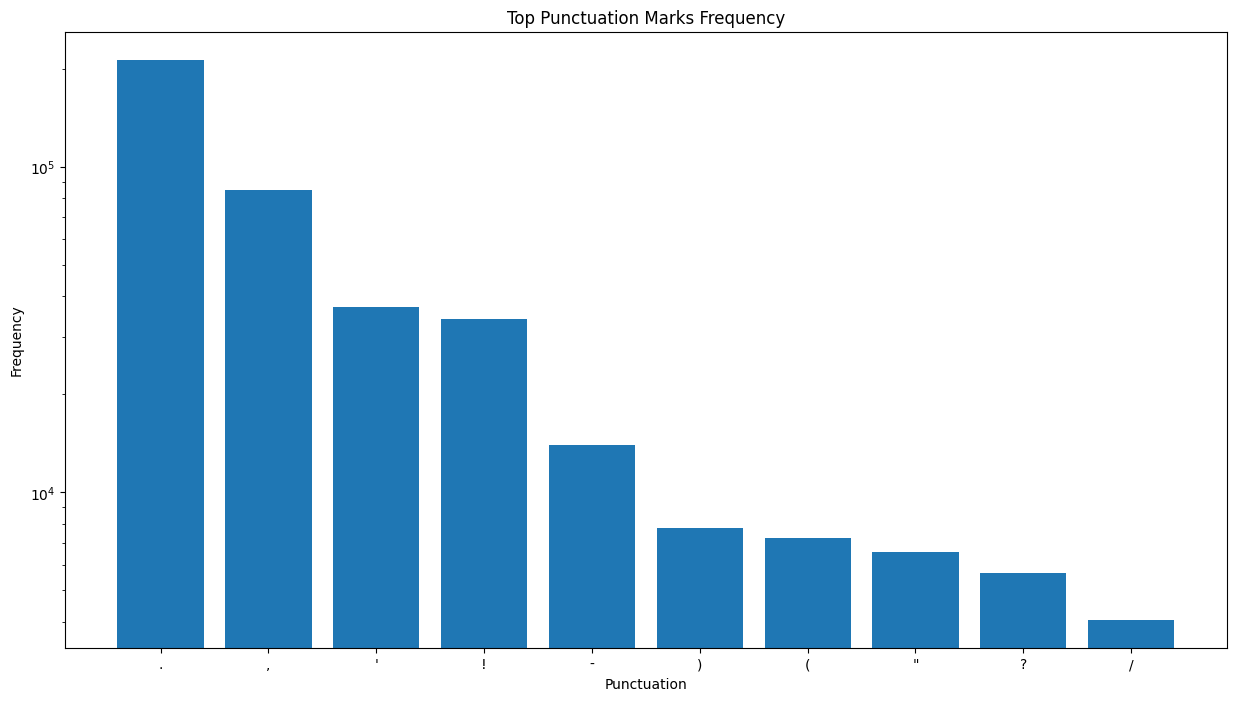

Average character length of text: 188.10 characters
Average character length of subject: 23.71 characters
Average word length of text: 27.14 words
Average word length of subject: 3.48 words

Most common words:
service: 27164
quicken: 22811
customer: 20632
great: 20051
asda: 17884
order: 15842
time: 14573
product: 14017
use: 13418
would: 12195
delivery: 11659
get: 11220
years: 10143
easy: 8972
one: 8930
flashbay: 8417
good: 8146
like: 8103
using: 7626
dont: 7558
support: 7275
work: 7054
used: 6982
back: 6900
never: 6308
helpful: 6273
online: 6266
even: 6248
got: 6111
still: 5906
ive: 5855
could: 5838
quick: 5829
items: 5797
help: 5758
company: 5614
shopping: 5585
store: 5484
experience: 5477
received: 5218
products: 5206
told: 5200
im: 5188
account: 5183
many: 5118
quality: 5068
fast: 5003
always: 4851
really: 4841
need: 4827
problem: 4777
refund: 4759
ordered: 4749
way: 4727
accounts: 4702
money: 4699
headset: 4658
new: 4643
go: 4567
process: 4547
day: 4524
days: 4518
issue: 4416
well:

In [157]:
#Basic text preprocessing
print("Original number of rows:", len(df_trustpilot))

#Removing the stop words
stop_words = set(stopwords.words('english'))

# Email extraction
pat_mail = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
df_trustpilot['email'] = df_trustpilot['text'].str.extract(pat_mail, expand=False)

# Check unique emails found
print("Number of reviews containing emails:", df_trustpilot['email'].unique())

# URL extraction
pat_link = r'(https?://(?:www\.)?\w+\.\w{2,}(?:/\S*)?)'
df_trustpilot['link'] = df_trustpilot['text'].str.extract(pat_link, expand=False)

# Check unique links found
print("Number of reviews containing URLs:", df_trustpilot['link'].unique())

# List of punctuation marks to count
punctuation_marks = list(string.punctuation)

# Store punctuation counts in a single column as dictionaries
df_trustpilot['punctuation_counts'] = df_trustpilot['text'].apply(
    lambda x: dict(Counter(c for c in x if c in punctuation_marks))
)

# Aggregate all punctuation counts
all_punctuation_counts = Counter()
df_trustpilot['punctuation_counts'].apply(lambda x: all_punctuation_counts.update(x))

# Visualize the most frequent punctuation marks
top_punctuation = dict(all_punctuation_counts.most_common(10))  # Top 10 most frequent
plt.figure(figsize=(15, 8))
plt.bar(top_punctuation.keys(), top_punctuation.values())
plt.yscale('log')
plt.title("Top Punctuation Marks Frequency")
plt.xlabel("Punctuation")
plt.ylabel("Frequency")
plt.show()

# Function to remove stop words from a given text
def remove_stopwords(text):
    if isinstance(text, str):
        #Convert to lowercase
        text = text.lower()
        #Remove punctuation and special characters
        text = re.sub(r'[^\w\s]', '', text)
        #Properly tokenize the text
        words = word_tokenize(text)
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words)
    return text

# Rest of the original code continues as before...
df_trustpilot['text_processed'] = df_trustpilot['text'].apply(remove_stopwords)
df_trustpilot['subject_processed'] = df_trustpilot['subject'].apply(remove_stopwords)
df_trustpilot['answer_processed'] = df_trustpilot['answer'].apply(remove_stopwords)

# Calculate character length for both text and subject columns
df_trustpilot['text_length'] = df_trustpilot['text_processed'].apply(len)
df_trustpilot['subject_length'] = df_trustpilot['subject_processed'].apply(len)
average_length = df_trustpilot['text_length'].mean()
average_subject_length = df_trustpilot['subject_length'].mean()
print(f"Average character length of text: {average_length:.2f} characters")
print(f"Average character length of subject: {average_subject_length:.2f} characters")

# Calculate average word length
df_trustpilot['text_word_length'] = df_trustpilot['text_processed'].apply(lambda x: len(x.split()))
df_trustpilot['subject_word_length'] = df_trustpilot['subject_processed'].apply(lambda x: len(x.split()))
avg_text_words = df_trustpilot['text_word_length'].mean()
avg_subject_words = df_trustpilot['subject_word_length'].mean()
print(f"Average word length of text: {avg_text_words:.2f} words")
print(f"Average word length of subject: {avg_subject_words:.2f} words")

# Combining both text and subject for common words analysis
all_text = ' '.join(df_trustpilot['text_processed']) + ' ' + ' '.join(df_trustpilot['subject_processed'])
# Properly tokenize the combined text
words = word_tokenize(all_text.lower())
# Counting the frequency of each word
word_counts = Counter(words)
# Get the 500 most common words
common_words = word_counts.most_common(500)
# Displaying the common words
print("\nMost common words:")
for word, count in common_words:
    print(f"{word}: {count}")

0.18691588785046728
0.4726767472909616


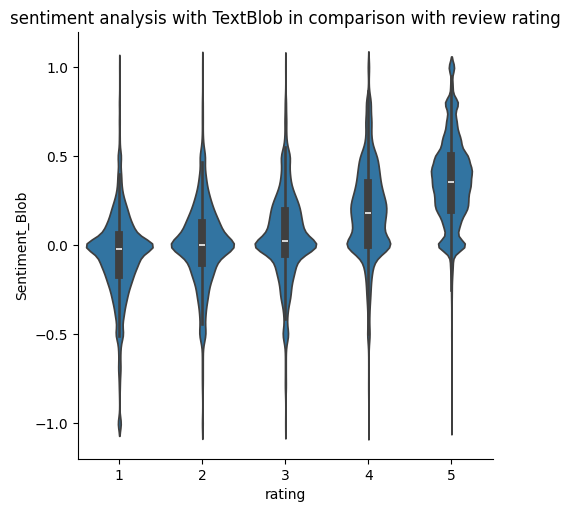

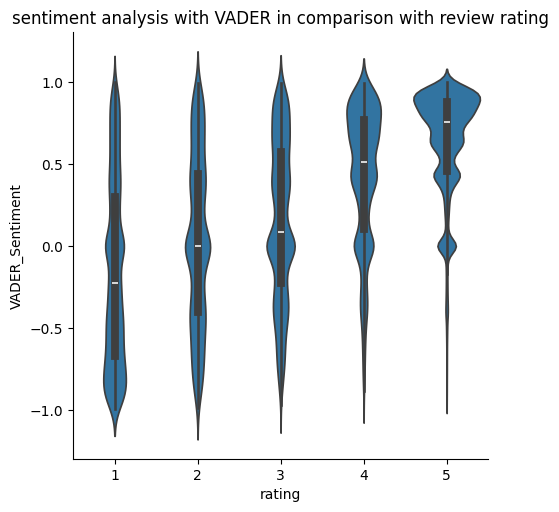

In [158]:
#Basic sentiment scores

#function returning the sentiment calculated by TextBlob
def sentiment_analysis(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity
# creating a new column with the sentiment from Text_blob
df_trustpilot['Sentiment_Blob'] = df_trustpilot['text_processed'].apply(lambda text: sentiment_analysis(str(text)))


sns.catplot(x="rating",y="Sentiment_Blob", kind="violin", data=df_trustpilot)
plt.title("sentiment analysis with TextBlob in comparison with review rating");


# Initialise VADER Sentiment-Analyzer
sia = SentimentIntensityAnalyzer()

# Function giving the VADER sentiment back
def vader_sentiment(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores['compound']

# creating new column with VADER_sentiment
df_trustpilot['VADER_Sentiment'] = df_trustpilot['text_processed'].apply(lambda text: vader_sentiment(str(text)))
df_trustpilot.head()



sns.catplot(x="rating",y="VADER_Sentiment", kind="violin", data=df_trustpilot)
plt.title("sentiment analysis with VADER in comparison with review rating");


# creating a new column with categorized values based on the TextBlob Sentiment
df_trustpilot["Sentiment_Blob_cat"]= pd.cut(df_trustpilot["Sentiment_Blob"], bins = [-1, -0.6, -0.2, 0.2, 0.6, 1], labels= [1, 2, 3, 4, 5])
df_trustpilot.head()


# creating a new column with categorized values based on the VADER Sentiment
df_trustpilot["Sentiment_VADER_cat"]= pd.cut(df_trustpilot["VADER_Sentiment"], bins = [-1, -0.6, -0.2, 0.2, 0.6, 1], labels= [1, 2, 3, 4, 5])
df_trustpilot.head()


# creating crosstabs of the actual rating compared to the rating comming from the TextBlob
cm = pd.crosstab(df_trustpilot.rating, df_trustpilot.Sentiment_Blob_cat, rownames = ["Rating"], colnames = ["Sentiment category from TextBlob"])
cm


# calculating true positives for TextBlob
TP_TextBlob = cm.loc[1,1]+cm.loc[2,2]+cm.loc[3,3]+cm.loc[4,4]+cm.loc[5,5]
total_num = df_trustpilot.shape[0]
TP_rate = TP_TextBlob/total_num
print(TP_rate)


# creating crosstabs of the actual rating compared to the rating comming from the VADER
cm = pd.crosstab(df_trustpilot.rating, df_trustpilot.Sentiment_VADER_cat, rownames = ["Rating"], colnames = ["Sentiment category from VADER"])
cm


# calculating true positives for VADER
TP_VADER = cm.loc[1,1]+cm.loc[2,2]+cm.loc[3,3]+cm.loc[4,4]+cm.loc[5,5]
total_num = df_trustpilot.shape[0]
TP_rate = TP_VADER/total_num
print(TP_rate)

Number of words/phrases analyzed: 41

Word frequencies:
not satisfied                  0
worth the price                0
easy to use                    0
attention to detail            0
waste of money                 0
never again                    0
very satisfied                 0
disappointing experience      11
poor communication            17
unresponsive                  19
low quality                   34
friendly staff                37
defective product             40
prompt response               41
inconvenient                  63
dissatisfied                  67
overpriced                    83
poor quality                  95
easy process                  99
terrible service             112
unprofessional               122
unreliable                   132
poor customer service        136
fast delivery                170
exceeded expectations        205
disappointing                211
quick turnaround             229
unhelpful                    248
excellent service   

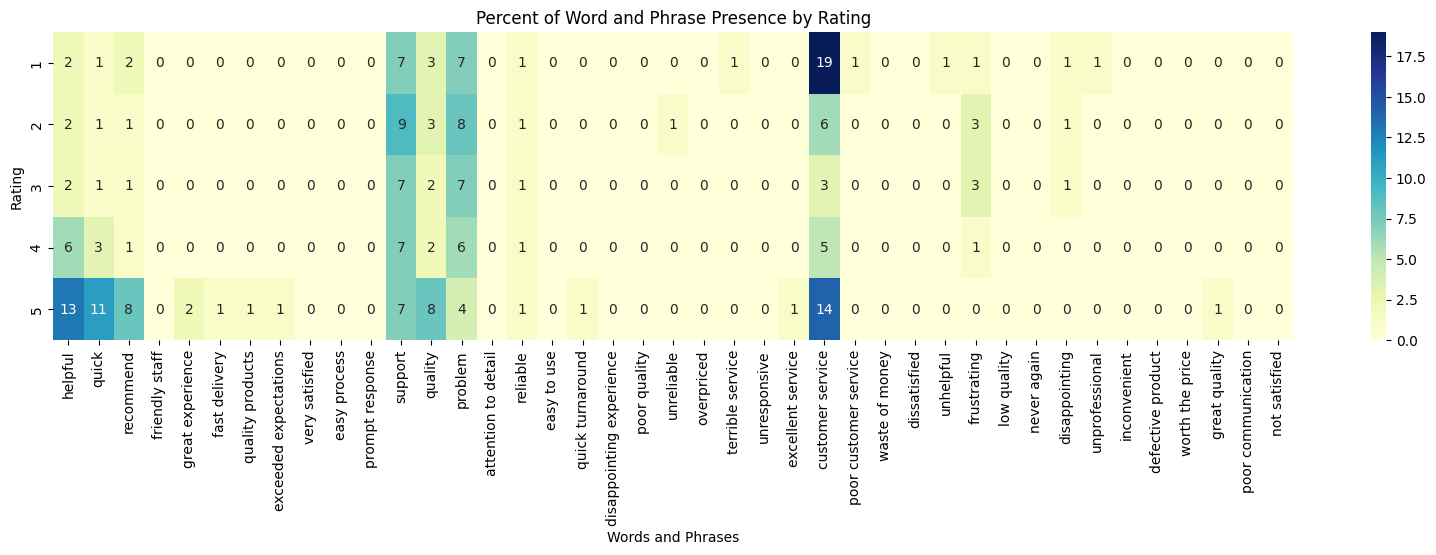

In [159]:
# Creating a list of words and phrases to search in the review test
word_list = ['helpful', 'quick', 'recommend', 'friendly staff', 'great experience', 'fast delivery', 'quality products', 
             'exceeded expectations', 'very satisfied', 'easy process', 'prompt response', 'support', 'quality', 'problem', 
             'attention to detail', 'reliable', 'easy to use', 'quick turnaround', 'disappointing experience', 'poor quality', 
             'unreliable', 'overpriced', 'terrible service', 'unresponsive', 'excellent service', 'customer service',
             'poor customer service', 'waste of money', 'dissatisfied', 'unhelpful', 'frustrating', 'low quality', 
             'never again', 'disappointing', 'unprofessional', 'inconvenient', 'defective product', 'worth the price', 
             'great quality', 'poor communication', 'not satisfied']
print("Number of words/phrases analyzed:", len(word_list))

# Create a temporary DataFrame with word occurrences
temp_df = pd.DataFrame()
for word in word_list:
    temp_df[word] = df_trustpilot['text_processed'].str.contains(fr'\b{word}\b', case=False, na=False).astype(int)

# Calculate word frequencies
column_totals = temp_df.sum().sort_values(ascending=True)
print("\nWord frequencies:")
print(column_totals)

# Group by rating and calculate frequencies
result_df = pd.DataFrame()
for word in word_list:
    result_df[word] = df_trustpilot.groupby('rating')['text_processed'].apply(
        lambda x: x.str.contains(fr'\b{word}\b', case=False, na=False).mean() * 100).round(0)

# Display normalized frequencies
plt.figure(figsize=(20, 4))
sns.heatmap(result_df, annot=True, cmap="YlGnBu", fmt='g')  # fmt='g' for whole numbers
plt.xlabel("Words and Phrases")
plt.ylabel("Rating")
plt.title("Percent of Word and Phrase Presence by Rating")
plt.show()

In [160]:
#Rearranging the order of the columns
print("Current column order:", df_trustpilot.columns.tolist())

df_trustpilot.rename(columns={'VADER_Sentiment': 'Sentiment_VADER'}, inplace=True)


display(df_trustpilot.head())

df_trustpilot = df_trustpilot[['rating', 'location', 'username', 'number_reviews', 'verification','repeat_reviewer', 'repeat_reviewer_encoded', 'company', 
                               'text', 'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob', 'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat', 
                               'subject', 'subject_processed', 'subject_length', 'subject_word_length', 'answer', 'answer_processed', 'answered_encoded', 
                               'date_of_experience', 'date_posted', 'local_date_posted', 'month_local', 'local_hour', 'time_of_day', 
                               'day_of_week_posted', 'day_type', 'days_between_experience_and_post', 'review_time', 'review_time_encoded']]

Current column order: ['username', 'number_reviews', 'location', 'rating', 'text', 'date_of_experience', 'date_posted', 'verification', 'subject', 'answer', 'company', 'local_hour', 'local_date_posted', 'days_between_experience_and_post', 'day_of_week_posted', 'time_of_day', 'day_type', 'answered_encoded', 'repeat_reviewer', 'repeat_reviewer_encoded', 'review_time', 'review_time_encoded', 'month_local', 'email', 'link', 'punctuation_counts', 'text_processed', 'subject_processed', 'answer_processed', 'text_length', 'subject_length', 'text_word_length', 'subject_word_length', 'Sentiment_Blob', 'VADER_Sentiment', 'Sentiment_Blob_cat', 'Sentiment_VADER_cat']


,username,number_reviews,location,rating,text,date_of_experience,date_posted,verification,subject,answer,company,local_hour,local_date_posted,days_between_experience_and_post,day_of_week_posted,time_of_day,day_type,answered_encoded,repeat_reviewer,repeat_reviewer_encoded,review_time,review_time_encoded,month_local,email,link,punctuation_counts,text_processed,subject_processed,answer_processed,text_length,subject_length,text_word_length,subject_word_length,Sentiment_Blob,Sentiment_VADER,Sentiment_Blob_cat,Sentiment_VADER_cat
0,Rob Crane,2,CA,5,The company rep I worked with made my transact...,2024-06-15,2024-10-23 04:17:44,Redirected,The company rep I worked with made my…,0,Flashbay,21,2024-10-22,129,1,Evening,Business Day,0,repeat,1,late_review,0,10,NaN,NaN,{'.': 3},company rep worked made transaction smooth qui...,company rep worked made,0,110,23,15,4,0.311111,0.4215,4,4
1,Pat Anderson,1,US,5,I highly recommend using Flashbay. Immediately...,2024-10-16,2024-10-16 19:34:05,Verified,I highly recommend using Flashbay,0,Flashbay,12,2024-10-16,0,2,Business Hours,Business Day,0,one-time,0,quick_review,1,10,NaN,NaN,"{'.': 2, '!': 2, ''': 1}",highly recommend using flashbay immediately or...,highly recommend using flashbay,0,202,31,26,4,0.345417,0.6233,4,5
2,Margarita Orlova,1,CZ,5,I had the pleasure of working with Shelby Gibs...,2024-10-10,2024-10-17 10:27:44,Verified,Great customer service,0,Flashbay,10,2024-10-17,7,3,Business Hours,Business Day,0,one-time,0,late_review,0,10,NaN,NaN,"{'.': 4, ',': 1}",pleasure working shelby gibson large order nee...,great customer service,0,175,22,24,3,0.320223,0.9643,4,5
3,Paola Rivas,1,US,5,I had a fantastic experience with Brian Truong...,2024-10-21,2024-10-21 22:38:50,Verified,Outstanding Support and Attentive Service,0,Flashbay,15,2024-10-21,0,0,Business Hours,Business Day,0,one-time,0,quick_review,1,10,NaN,NaN,"{'.': 2, ',': 2, '!': 1}",fantastic experience brian truong attentive tr...,outstanding support attentive service,0,122,37,14,4,0.600000,0.9169,4,5
4,Fiona Mckelvey Keenan,3,CA,5,My number-one go-to for computer accessories. ...,2024-07-11,2024-10-23 04:09:05,Not Verified,My number-one go-to for computer…,0,Flashbay,21,2024-10-22,103,1,Evening,Business Day,0,repeat,1,late_review,0,10,NaN,NaN,"{'-': 2, '.': 3, ',': 1, '!': 1}",numberone goto computer accessories rachel sup...,numberone goto computer,0,155,23,18,3,0.386667,0.8553,4,5


In [161]:
#Last check

print(df_trustpilot.columns)
print(df_trustpilot.info())
display(df_trustpilot.head())

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 64414 entries, 0 to 78403
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            64414 non-null  int64  

,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,text_length,text_word_length,Sentiment_Blob,Sentiment_Blob_cat,Sentiment_VADER,Sentiment_VADER_cat,subject,subject_processed,subject_length,subject_word_length,answer,answer_processed,answered_encoded,date_of_experience,date_posted,local_date_posted,month_local,local_hour,time_of_day,day_of_week_posted,day_type,days_between_experience_and_post,review_time,review_time_encoded
0,5,CA,Rob Crane,2,Redirected,repeat,1,Flashbay,The company rep I worked with made my transact...,company rep worked made transaction smooth qui...,110,15,0.311111,4,0.4215,4,The company rep I worked with made my…,company rep worked made,23,4,0,0,0,2024-06-15,2024-10-23 04:17:44,2024-10-22,10,21,Evening,1,Business Day,129,late_review,0
1,5,US,Pat Anderson,1,Verified,one-time,0,Flashbay,I highly recommend using Flashbay. Immediately...,highly recommend using flashbay immediately or...,202,26,0.345417,4,0.6233,5,I highly recommend using Flashbay,highly recommend using flashbay,31,4,0,0,0,2024-10-16,2024-10-16 19:34:05,2024-10-16,10,12,Business Hours,2,Business Day,0,quick_review,1
2,5,CZ,Margarita Orlova,1,Verified,one-time,0,Flashbay,I had the pleasure of working with Shelby Gibs...,pleasure working shelby gibson large order nee...,175,24,0.320223,4,0.9643,5,Great customer service,great customer service,22,3,0,0,0,2024-10-10,2024-10-17 10:27:44,2024-10-17,10,10,Business Hours,3,Business Day,7,late_review,0
3,5,US,Paola Rivas,1,Verified,one-time,0,Flashbay,I had a fantastic experience with Brian Truong...,fantastic experience brian truong attentive tr...,122,14,0.600000,4,0.9169,5,Outstanding Support and Attentive Service,outstanding support attentive service,37,4,0,0,0,2024-10-21,2024-10-21 22:38:50,2024-10-21,10,15,Business Hours,0,Business Day,0,quick_review,1
4,5,CA,Fiona Mckelvey Keenan,3,Not Verified,repeat,1,Flashbay,My number-one go-to for computer accessories. ...,numberone goto computer accessories rachel sup...,155,18,0.386667,4,0.8553,5,My number-one go-to for computer…,numberone goto computer,23,3,0,0,0,2024-07-11,2024-10-23 04:09:05,2024-10-22,10,21,Evening,1,Business Day,103,late_review,0


In [162]:
import os

os.makedirs('data', exist_ok=True)

csv_path = 'data/data_trustpilot.csv'
df_trustpilot.to_csv(csv_path, index=False)
print(f"DataFrame exported to {csv_path}")

DataFrame exported to data/data_trustpilot.csv
